# 1. Imports

In [21]:
# scikit-learn
from sklearn import set_config # return pd.DataFrame from transformers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest

# others
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import feature_distribution_plot, scree_plot, decision_boundary_plot

<hr>

# 2. Settings

In [2]:
set_config(transform_output='pandas')

<hr>

# 3. Preprocess the Data Set

In [3]:
df = pd.read_csv('./data/hcvdat33_Complete.csv')

In [4]:
df.drop(columns=['Unnamed: 0', 'Sex'], inplace=True)

In [5]:
df_nas = df.isnull()
df_nas_sum = df_nas.sum()
print("Sum of NAs in data:")
print(df_nas_sum)

Sum of NAs in data:
Category     0
Age          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


<hr>

# 4 Impute Data

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [7]:
#df_imputed = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10)).fit_transform(df)
#df_imputed

<hr>

# 5. Train Decision Tree Classifier

In [30]:
# Assuming df is your DataFrame
# Extract features and target variable
X = df.drop(columns=['Category'])  # Features (excluding the first column)
y = df['Category']  # Target variable (the first column)

# Convert categories to numeric labels for color mapping
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# extract class names from laben encoder
class_names = label_encoder.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=4)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# print metrics
print(f"Accuracy: {accuracy}")
print(f'Depth: {clf.get_depth()} levels')

Accuracy: 0.8617886178861789
Depth: 4 levels


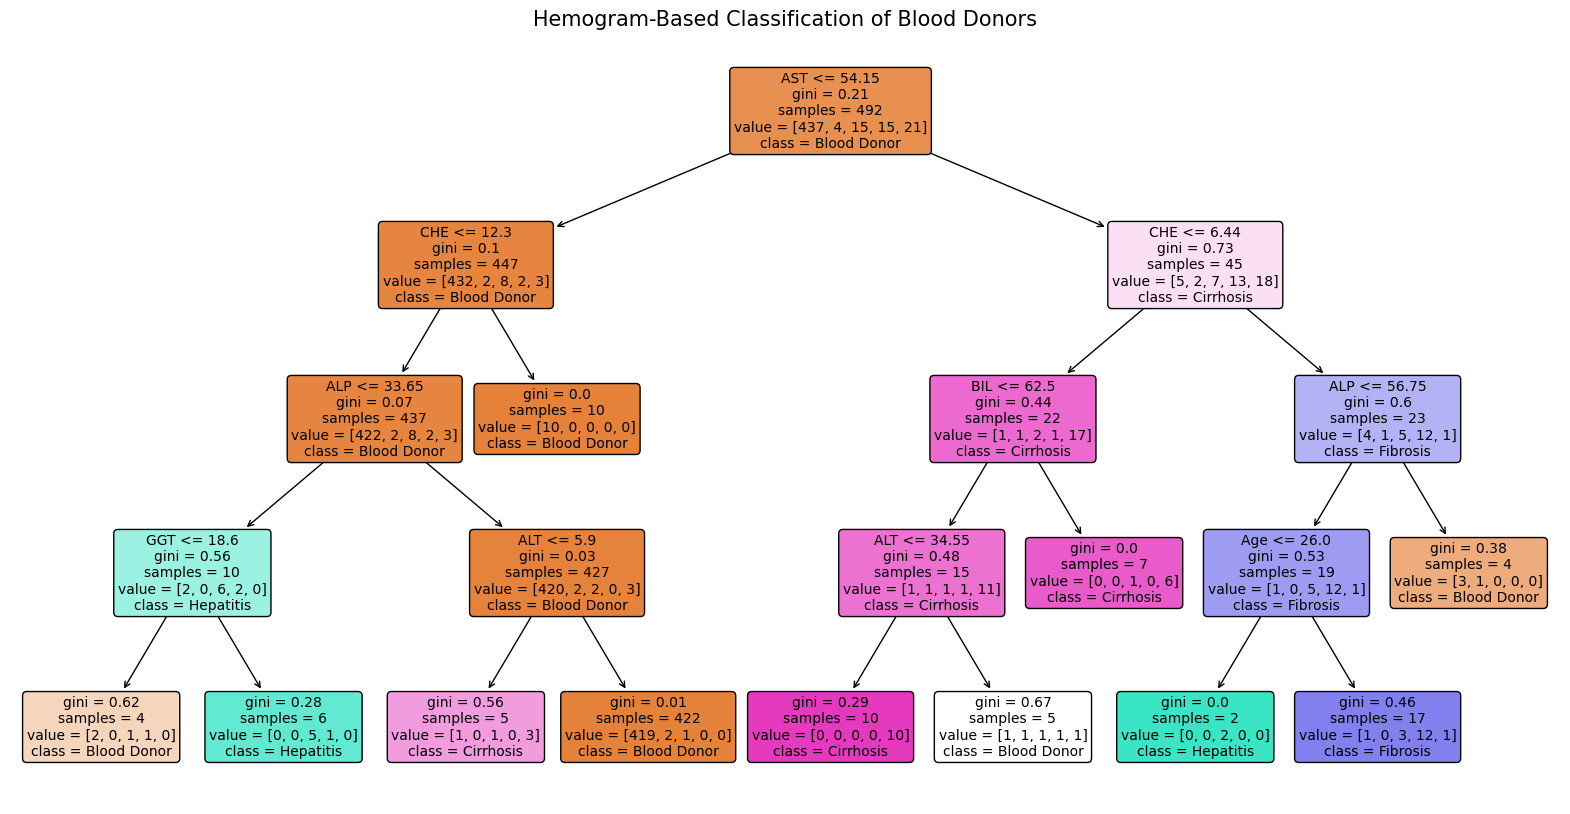

In [31]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=class_names, impurity=True, rounded=True, proportion=False, precision=2, fontsize=10)

plt.title('Hemogram-Based Classification of Blood Donors', fontsize=15)

plt.show()

